# Setting

## Load Library

In [1]:
import pandas as pd
import numpy as np

from scipy import stats 
from tabulate import tabulate

import matplotlib.pyplot as plt
import seaborn as sns

import random
import os

In [2]:
from sklearn.ensemble import RandomForestClassifier

In [3]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score # 정확도
from sklearn.metrics import precision_score # 정밀도
from sklearn.metrics import recall_score # 재현율
from sklearn.metrics import f1_score # F1-Score
from sklearn.metrics import confusion_matrix

## Fix Random Seed

In [4]:
def my_seed_everywhere(seed):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    os.environ["PYTHONHASHSEED"] = str(seed) # os

In [5]:
# seed를 고정시킴으로써 동일한 결과값 출력
SEED = 42
my_seed_everywhere(SEED)

# Load Data Set

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# 자신의 경로에 맞게 수정
path_file = '/content/drive/MyDrive/UNIST/AICP/data/dynmom_dat.csv'

df = pd.read_csv(path_file)

# Preprocessing

## Set Index

In [8]:
# 'DATE'를 칼럼 대신 인덱스로 사용
df.index = df['DATE']
df = df.drop(columns='DATE')

## Drop Rows & Cols

In [9]:
# 결측치 제거 및 모델 학습에 불필요한 칼럼 제거
drop_null_df = df.dropna()
drop_cols_df = drop_null_df.drop(columns=['winner', 'loser', 'form_date'])

## Generate Target

### Normal

In [10]:
# 'wml'의 양수 여부를 기준으로 'pos_wml' 라벨 생성
def normal_wml(df):

  cond_wml = (df['wml']>=0)
  df.loc[cond_wml, 'pos_wml'] = 1
  df.loc[~cond_wml, 'pos_wml'] = 0

  df.drop(columns=['wml'], inplace=True)

  POS_WML = df['pos_wml'].value_counts()
  print(f' Ratio : {POS_WML[0]/POS_WML[1]}')
  print(POS_WML)

  return df

In [11]:
dynmom = normal_wml(drop_cols_df)

 Ratio : 0.5634379263301501
1.0    733
0.0    413
Name: pos_wml, dtype: int64


# Modeling

## Rolling Windows

In [12]:
def Roling_Windows(data, window_size, method, model, model_name, plot=True, plot_feature=True):

  # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
  result_dict = {
    'TRAIN_START_DATE':[],
    'TRAIN_END_DATE':[],
    'TEST_DATE':[],
    'Actual_POS_WML':[],
    f'{model_name}_PRED_POS_WML':[]
  }

  df_feature = pd.DataFrame()

  i = 0

  # 모델 학습이 종료되는 지점 설정
  end = data.shape[0] - window_size - 1

  while True:

    # 모델 학습 중지
    if i == end:
      print('Prediction using machine learning has ended.')
      break
    
    # Rolling Fixed Window
    if method == 'Fixed':
      MODEL = model
      train = data.iloc[0+i:window_size+1+i]

    # Rolling Expanding Window
    elif method == 'Expanding':
      MODEL = model
      train = data.iloc[0:window_size+1+i]
    
    # 'method' 잘못입력한 경우
    else:
      print("Make sure to set the method to either 'Fixed' or 'Expanding'.")
      break
    
    # 테스트 데이터 설정
    test = data.iloc[[window_size+1+i]]

    # Features와 Target 구분
    X_train = train.drop(columns=['pos_wml'])
    y_train = train['pos_wml']

    X_test = test.drop(columns=['pos_wml'])
    y_test = test['pos_wml'] 

    # 모델 학습 및 추론
    MODEL.fit(X_train, y_train)
    pred_test = MODEL.predict(X_test)

    # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
    result_dict['TRAIN_START_DATE'].append(train.index[0])
    result_dict['TRAIN_END_DATE'].append(train.index[-1])
    result_dict['TEST_DATE'].append(test.index[0])

    result_dict['Actual_POS_WML'].append(list(y_test)[0])
    result_dict[f'{model_name}_PRED_POS_WML'].append(pred_test[0])

    # 트리 기반 모델 (사이킷런)의 Feature Importance 정보 수집
    feature_importances = MODEL.feature_importances_
    df_ft_importance = pd.DataFrame(feature_importances, index = X_train.columns).T
    df_ft_importance.index = y_test.index
    df_feature = pd.concat([df_feature, df_ft_importance])

    i += 1

  result = pd.DataFrame(result_dict)
  result.index = df_feature.index

  result = pd.concat([result, df_feature], axis=1)
  result = result.set_index('TEST_DATE')
  
  # 모델 성능 시각화
  if plot == True:
    plot_result(result, method, model_name)
  
  # 모델의 변수 중요도 시각화
  if plot_feature == True:
    plot_feature_importances(df_feature)
    print()

  # 학습 및 테스트 데이터 정보, 실제값과 예측값 정보, 변수 중요도 정보
  return result

In [13]:
# 모델 성능 시각화
def plot_result(data, method, model_name):
  print('\nPerformance results of the model\n')

  # Confusion Matrix & etc
  print(classification_report(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML']))

  # Accuracy, Precision, Recall, F1 Score
  accuracy = accuracy_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  precision = precision_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  recall = recall_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  F1_score = f1_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])

  print(f'\naccuracy : {accuracy}')
  print(f'\nprecision : {precision}')
  print(f'\nrecall : {recall}')
  print(f'\nF1-Score : {F1_score}\n')
  
  # Visualization Confusion Matrix
  confusion = confusion_matrix(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  sns.heatmap(confusion, annot=True, fmt='g')
  plt.title(f'Performance results ({method}) of the {model_name} model')
  
  plt.show()

In [14]:
# Feature Importance 시각화
def plot_feature_importances(data):

  print('\nFeature Importance of the model\n')

  # 날짜 별 Feature Importance 변화 추이
  plt.figure(figsize=(15, 5))
  for col in data.columns:

    sns.lineplot(data=data,
                x=data.index,
                y=col,
                label=col,
                alpha=0.3)
    
    plt.title('Feature importances using MDI')
    plt.xlabel('DATE')
    plt.ylabel('Mean decrease in impurity')
    plt.xticks([data.index[i] for i in range(0,len(data.index), 12)])
    plt.tick_params(axis='x',
                      direction='out',
                      labelrotation=45,
                      length=1,
                      pad=10,
                      labelsize=5,
                      width=0.1)
  plt.show()

  # 각 변수 별 Feature Importance 통계값
  MEAN = display_feature_importance(data, method='mean')
  MAX = display_feature_importance(data, method='max')
  MIN = display_feature_importance(data, method='min')

  plt.figure(figsize=(15, 5))
  sns.barplot(data=MEAN,
              y=MEAN.index,
              x='mean_Feature_Importance')

  plt.show()
  print()

  FEATURE_IMPORTANCE = pd.concat([MEAN, MAX, MIN], axis=1)
  display(FEATURE_IMPORTANCE)

In [15]:
# 각 변수 별 Feature Importance 통계값
def display_feature_importance(data, method):
    feature_dict = {}
    for col in data.columns:
      if method=='mean':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].mean())

      if method=='max':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].max())
      
      if method=='min':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].min())
    
    feature_df = pd.DataFrame(feature_dict).T
    feature_df.columns = [method+'_'+'Feature_Importance']
    feature_df=feature_df.sort_values(by=method+'_'+'Feature_Importance', ascending=False)

    return feature_df

## Model

In [16]:
# 랜덤 포레스트 모델 사용 (트리 기반)
model = RandomForestClassifier(random_state=SEED)

## Inference

### Rolling Fixed Windows

Prediction using machine learning has ended.

Performance results of the model

              precision    recall  f1-score   support

         0.0       0.42      0.23      0.29       315
         1.0       0.67      0.83      0.74       590

    accuracy                           0.62       905
   macro avg       0.54      0.53      0.52       905
weighted avg       0.58      0.62      0.59       905


accuracy : 0.6220994475138122

precision : 0.6684782608695652

recall : 0.8338983050847457

F1-Score : 0.7420814479638009



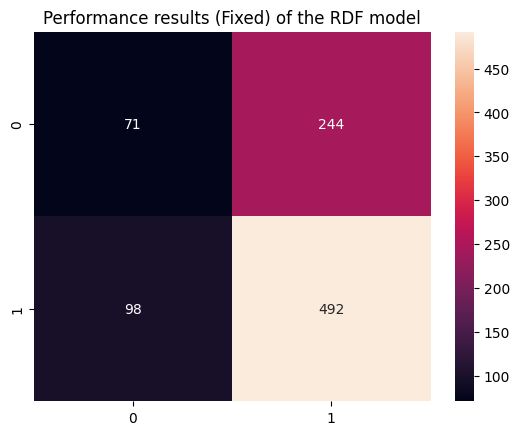


Feature Importance of the model



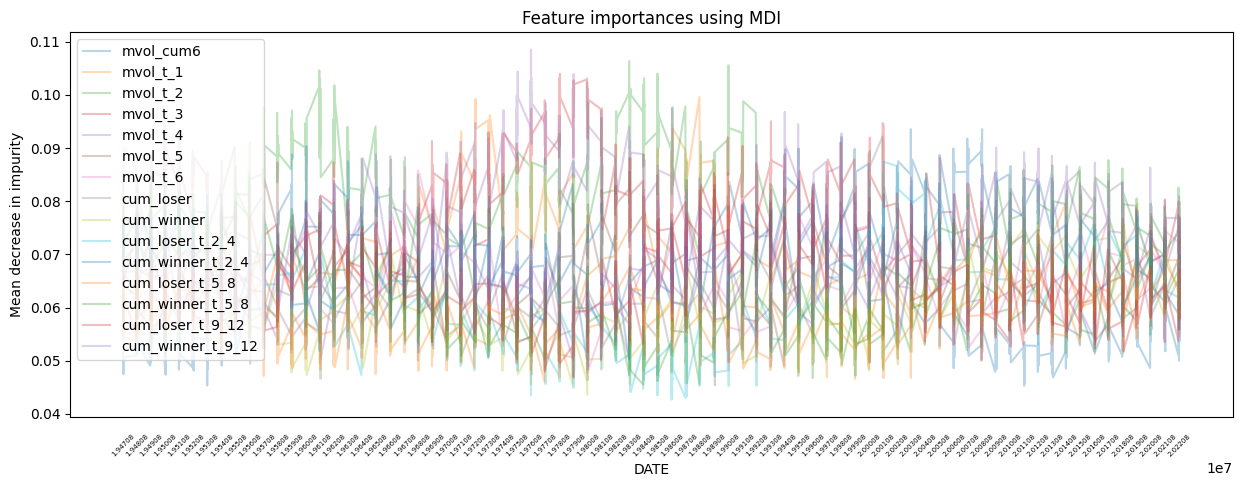

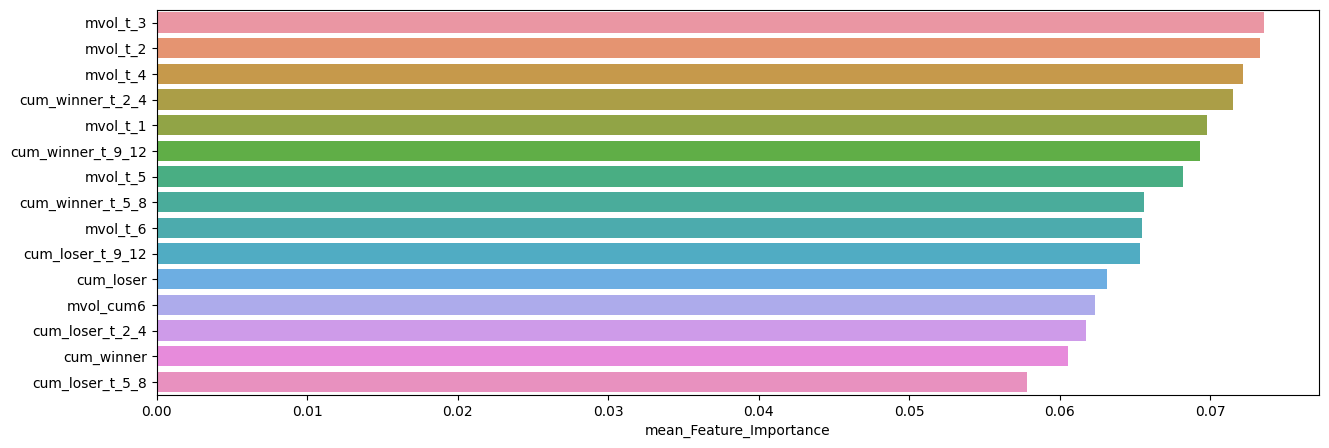

,mean_Feature_Importance,max_Feature_Importance,min_Feature_Importance
mvol_t_3,0.073565,0.103966,0.052317
mvol_t_2,0.073300,0.106363,0.048265
mvol_t_4,0.072194,0.108486,0.050457
cum_winner_t_2_4,0.071518,0.093544,0.050217
mvol_t_1,0.069828,0.099580,0.053613
cum_winner_t_9_12,0.069311,0.090102,0.048916
mvol_t_5,0.068192,0.094496,0.045354
cum_winner_t_5_8,0.065609,0.087735,0.045517
mvol_t_6,0.065470,0.090256,0.046702
cum_loser_t_9_12,0.065320,0.094716,0.046988


In [17]:
Fixed_RDF_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=model, # 사용할 모델
                                  model_name='RDF', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부

### Rolling Expanding Windows

Prediction using machine learning has ended.

Performance results of the model

              precision    recall  f1-score   support

         0.0       0.40      0.17      0.24       315
         1.0       0.66      0.86      0.75       590

    accuracy                           0.62       905
   macro avg       0.53      0.52      0.50       905
weighted avg       0.57      0.62      0.57       905


accuracy : 0.6232044198895028

precision : 0.6618985695708712

recall : 0.8627118644067797

F1-Score : 0.7490802060338485



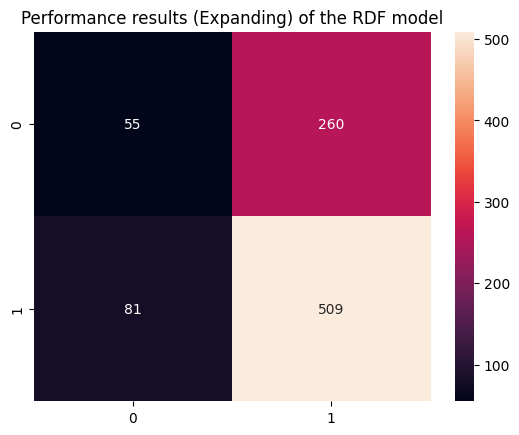


Feature Importance of the model



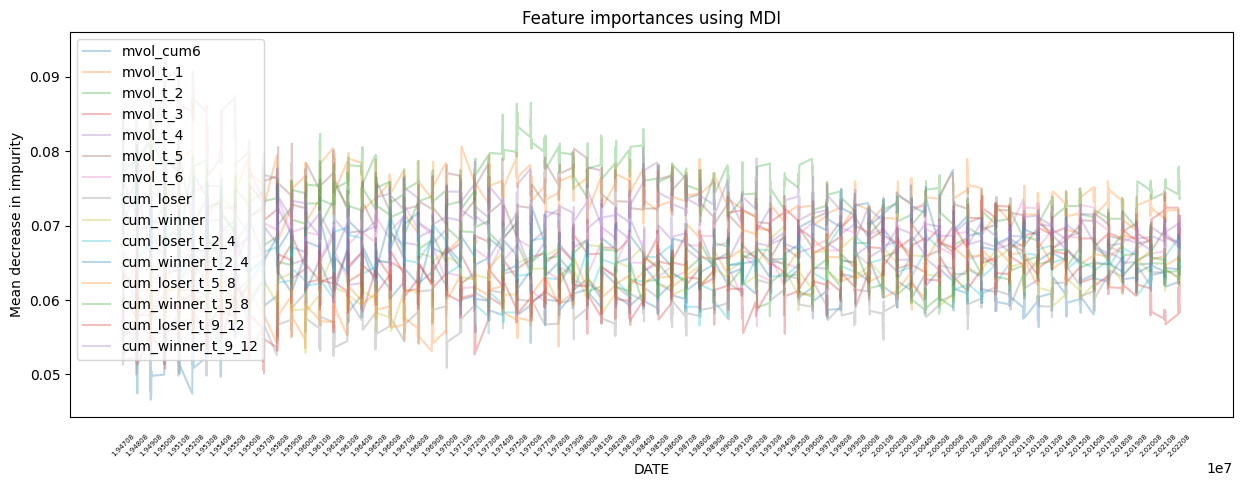

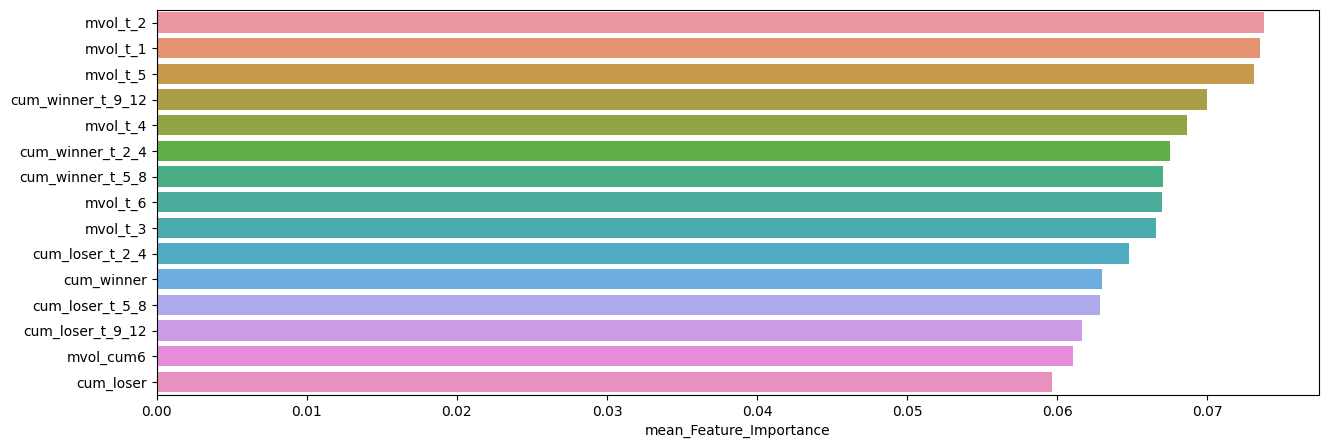

,mean_Feature_Importance,max_Feature_Importance,min_Feature_Importance
mvol_t_2,0.073750,0.086492,0.057529
mvol_t_1,0.073512,0.087151,0.066192
mvol_t_5,0.073099,0.093633,0.063911
cum_winner_t_9_12,0.069954,0.080474,0.059452
mvol_t_4,0.068607,0.081058,0.060884
cum_winner_t_2_4,0.067511,0.080849,0.058152
cum_winner_t_5_8,0.067069,0.085015,0.057816
mvol_t_6,0.066983,0.084579,0.056476
mvol_t_3,0.066570,0.075707,0.052820
cum_loser_t_2_4,0.064774,0.083911,0.055507


In [18]:
Expanding_RDF_Result = Roling_Windows(data=dynmom,
                                  window_size=240,
                                  method='Expanding',
                                  model=model,
                                  model_name='RDF',
                                  plot=True)